In [46]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import vistools          # image visualization toolbox
from skimage import io # read and write images

# global variable for setting the torch.load    map_location
if torch.cuda.is_available():
    loadmap = {'cuda:0': 'gpu'}
else:
    loadmap = {'cuda:0': 'cpu'}
    
#%matplotlib notebook
# Autoreload external python modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

from denoising_helpers import test_denoiser, PSNR
from models import DCTlike, DnCNN_pretrained_grayscale
from models import FFDNet, FFDNet_pretrained_grayscale
from vistools import unzip
from copy import copy
from tqdm import tqdm_notebook as tqdm
import utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Implementation of the noise model

Let's note $u(i)$ the intensity of the clean image at the pixel i. For a mixture of Poisson and Gaussian, the general form of the intensity of the noisy image is:
\begin{equation}
u_M(i)= \alpha P_i + N_i
\end{equation}

Where $P_i \sim \mathcal{P}(u(i))$ and $N_i \sim \mathcal{N}(c, \sigma^2)$.
The two variables are independent, hence finding the moments is straightforwards:

\begin{equation*}
\begin{array}{ccl}
\mathbb{E}(u_M(i))&=&\alpha u_i + c\\
\mathbb{V}(u_M(i))&=& \alpha^2 u_i +\sigma^2
\end{array}
\end{equation*}

Note that we in this case the expectation of the intensity of the noisy image does not match the intensity of the clean image, and we may observe a shift in the dynamic range of our picture. To address this problem, we can observe that if we set $z(i)=\frac{u_M(i)-c}{\alpha}$, then the variable $z$ follows the simpler model:
$$
z(i) = P_i + \frac{\sigma}{\alpha} n_i
$$

Where $n_i$ is a standard gaussian variable. So this simple transformation of the noisy input will always help us to go back to the case where $\alpha=1$ and $c=0$. Our implementation of denoising algorithms will make use of this property.

A first approach to handle this mixture of noise is to approximate it by a luminence-dependent Gaussian Noise, for which well-performing denoising algorithms exist. The noise model is then:

\begin{equation}
u_G(i)= u(i) + N_G(i)
\end{equation}

Where this time $N_G(i) \sim \mathcal{N}(0, \sigma(u_i)^2)$.
As the Gaussian distribution is fully characterized by its mean and variance, the closest match of the noise model (1) with the noise model (2) and parameters ($\alpha=1$, $c=0$) is to set $\sigma(u_i)^2= u_i + \sigma^2$. 

From this point the first part of our project aims to:
* Generate synthetic Poisson-Gaussian noise for some input image
* Compare this noise with its closest luminence-dependent Gaussian Noise 
* Compare the performance of Gaussian Denoising on both images: is the Gaussian approximation enough to provide a good denoising performance for the Poisson/Gaussian mixture?

Our implementation of the two types of noise added on an input image:
```python 
def mixture_noise(im, alpha, c, sig):
    poisson = alpha*np.random.poisson(lam=im)
    gaussian = np.random.normal(loc=c, scale=sig, size=im.shape)
    noisy_im = poisson + gaussian
    return minmax(noisy_im)

def gaussian_noise(im, alpha, c, sig):
    n = np.random.normal(size=im.shape)
    return alpha * im + c + np.sqrt(alpha**2 * im + sig**2) * n
```


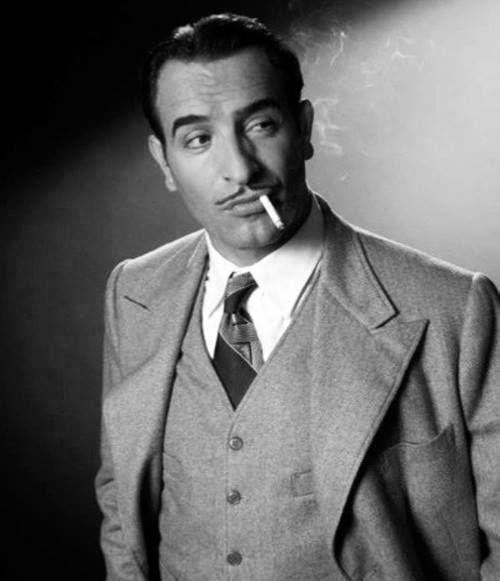
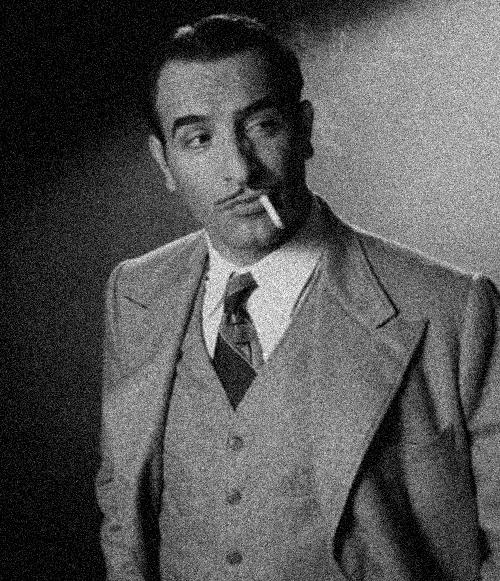
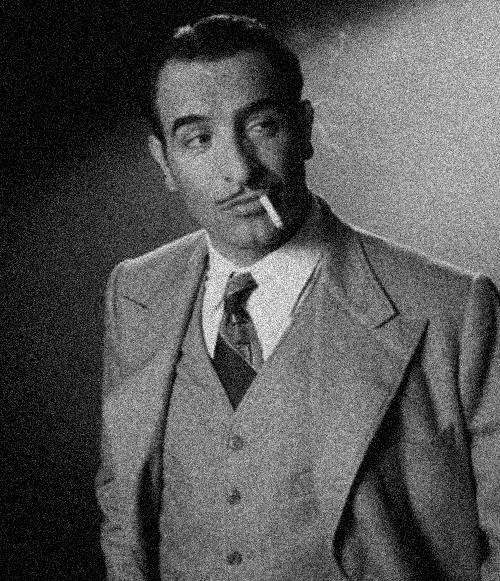

In [77]:
# Test
alpha0, c0, sigma0 = 0.8, 0., 20
im0 = utils.load_generate_noise('images/test007.jpg', alpha=alpha0, c=c0, sigma =sigma0, display=True)

We can visualize the two noise distributions on the total image:

C:\Users\dobau\Anaconda3\envs\py36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


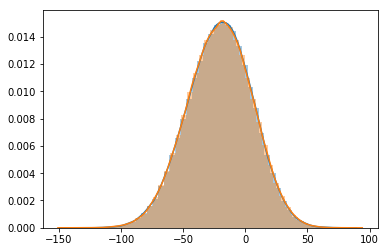

In [49]:
import seaborn
seaborn.distplot((im0[1]-im0[0]).flatten())
seaborn.distplot((im0[2]-im0[0]).flatten())

We can also compare for some intensity level:

C:\Users\dobau\Anaconda3\envs\py36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Expectation/Variance of Mixed Noise 15.950747, 37.919485
Expectation/Variance of Gaussian Noise 16.029910, 37.563776
Expectation/Variance of Mixed Noise 99.950844, 104.253951
Expectation/Variance of Gaussian Noise 100.129896, 104.382865
Expectation/Variance of Mixed Noise 159.691151, 156.199687
Expectation/Variance of Gaussian Noise 159.750292, 155.703789


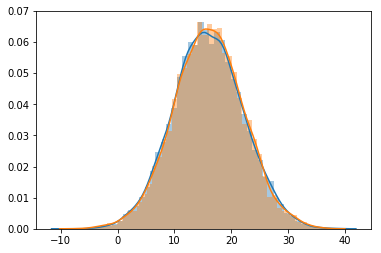

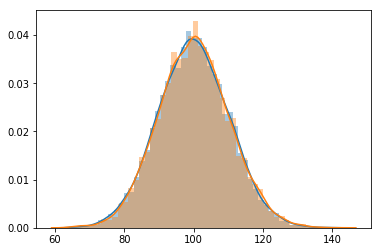

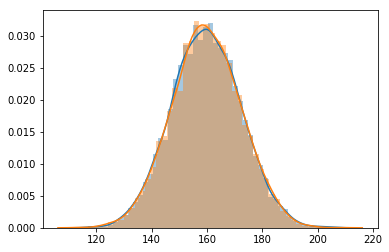

In [50]:
n_test, u, alpha_test, c_test, sig_test = 10000, 150, 0.8, 0., 5
    
utils.plot_dist_noise(20, n_test, alpha_test, c_test, sig_test)
utils.plot_dist_noise(125, n_test, alpha_test, c_test, sig_test)
utils.plot_dist_noise(200, n_test, alpha_test, c_test, sig_test)

## First denoising test with DnCNN

We test the performance of the DnCNN denoiser with our synthetic noise. The DnCNN assumes that the noise is gaussian of standard deviation $\sigma$, and performs the denoising with this parameter as input. In this test we ignore the luminance dependancy of the image, just to get a first lower bound of our expectation of performance. That means, instead of considering a standard deviation of $ \sqrt{ u_i + \sigma^2}$ we use the DnCNN corresponding to a noise level of $\sqrt{ \widehat{u_i} + \sigma^2}$ where $\widehat{u_i}$ is the mean intensity on the noisy picture.


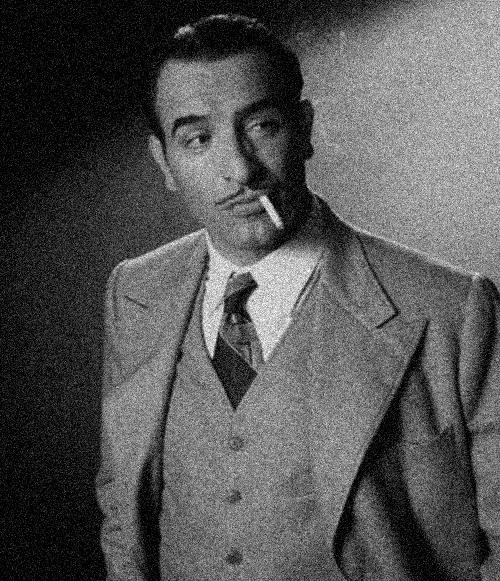
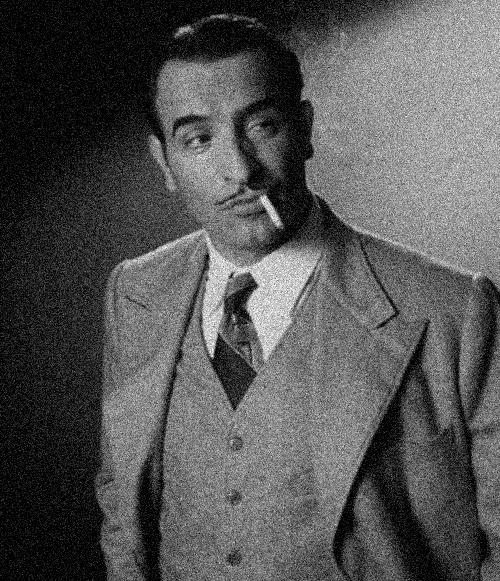
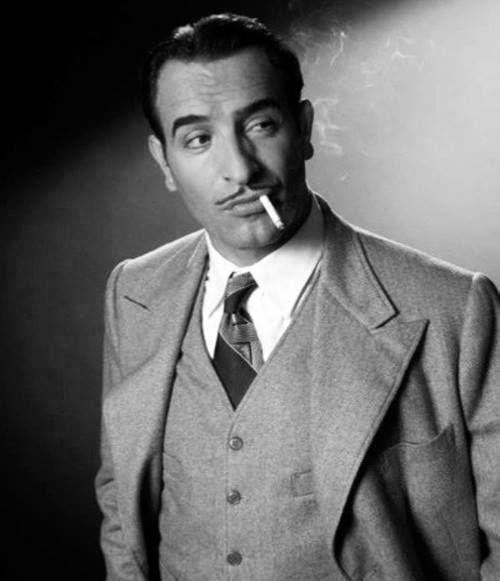
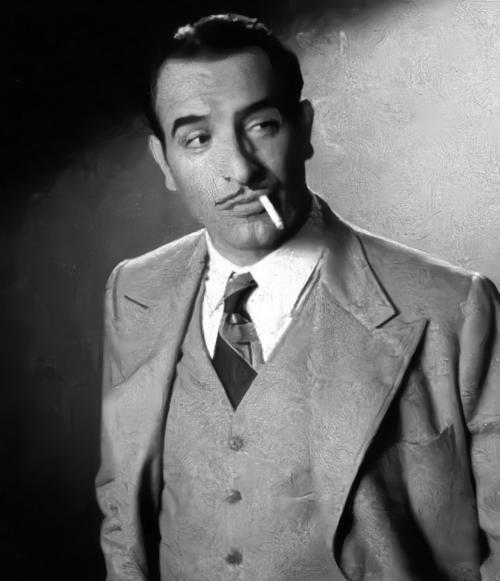
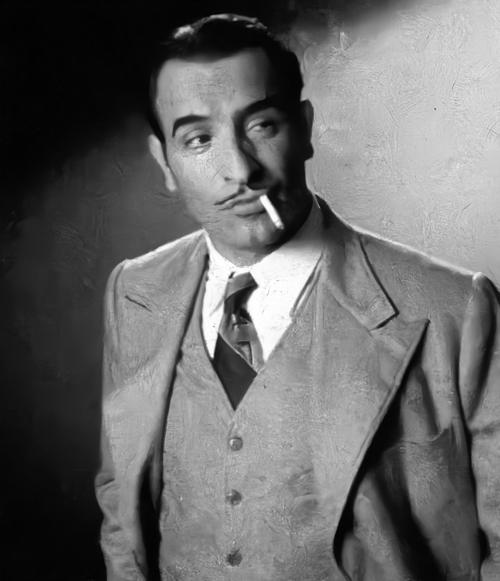

In [62]:
res_raw_dncnn = utils.test_raw_dncnn(alpha0, c0, sigma0, im0, display=True)

COMMENT

## Study of the noise

### Noise map on our example

We display the difference between noisy and clean image to observe the impact of the luminence-dependence of the variance on the noise.


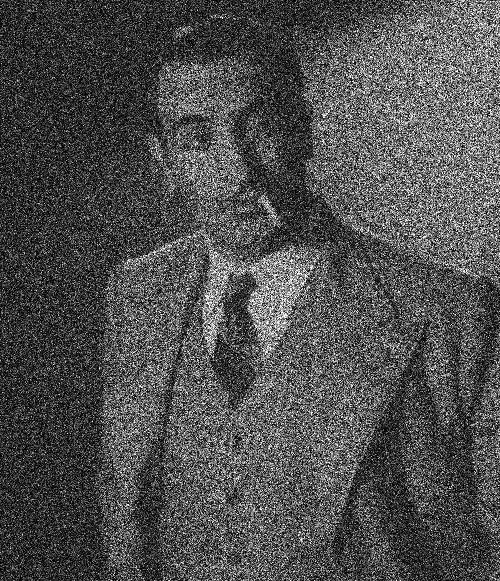
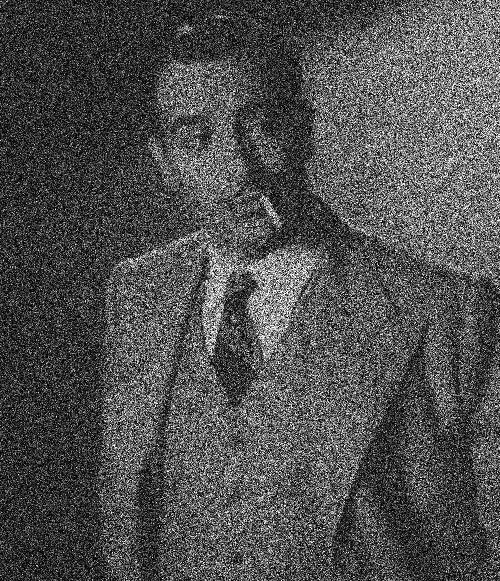

In [52]:
inflate = 3
im1 = utils.load_generate_noise('images/test007.jpg', alpha=alpha0, c=c0, sigma =sigma0, display=False)
vistools.display_gallery([np.abs(im0[1] - im0[0])*inflate, np.abs(im0[2] - im0[0])*inflate])

Now we try to perform the simple Anscombe transform for a Gaussian to figure if this transform can be sufficient in our case.

``` python
def VST_Gaussian(im, alpha, c, sigma):
    """
    :param im: Input image
    :param sigma: Standard deviation of the Gaussian Noise
    :return: Anscombe transform of the input image, rescaled in (0, 255),
     and the corresponding standard deviation
    """
    im2 = (copy(im) - c)/alpha
    fu = np.sqrt(im2 + (sigma/alpha)**2)
    a = np.sqrt(1 + (sigma/alpha)**2)
    b = np.sqrt(255 + (sigma/alpha)**2)
    return (fu - a)/(b-a)*255., a, b


def inv_VST_Gaussian(im, alpha, c, sigma, param):
    """
    :param im: Output image of a VST
    :param sigma: Standard deviation of the Gaussian Noise
    :param std: Standard deviation of the noise of the transformed image
    :return: Inverse VST Transform
    """
    new_im = copy(im) * (param[1] - param[0])/255. + param[0]
    return new_im**2 - (sigma/alpha) ** 2
```

In [ ]:
utils.test_VST(im0, alpha0, c0, sigma0)
utils.test_VST_bijective(im0[2], alpha0, c0, sigma0)

With the transform the value of $\sigma$ to use in the denoiser becomes the one that we output with the VST:


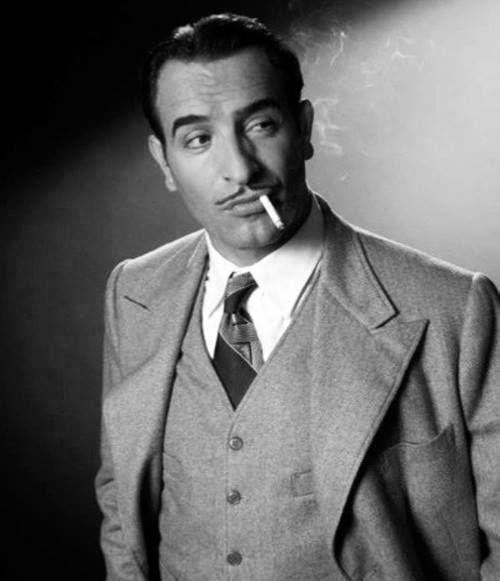
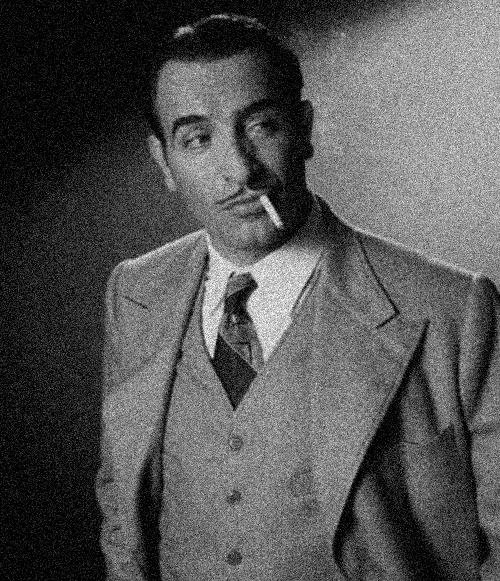
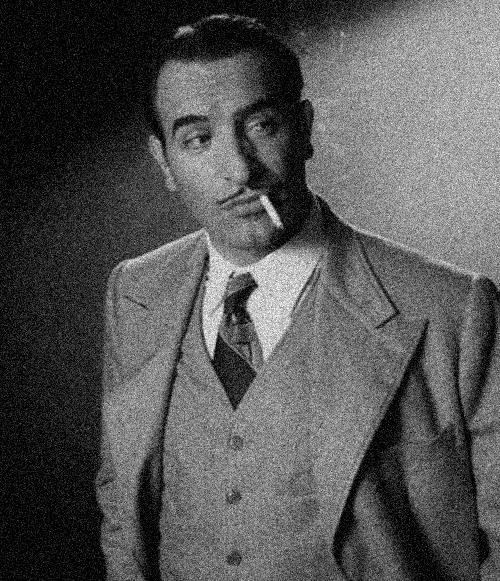
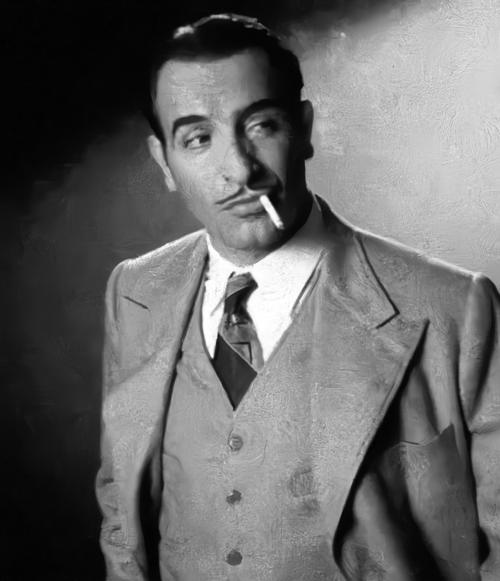
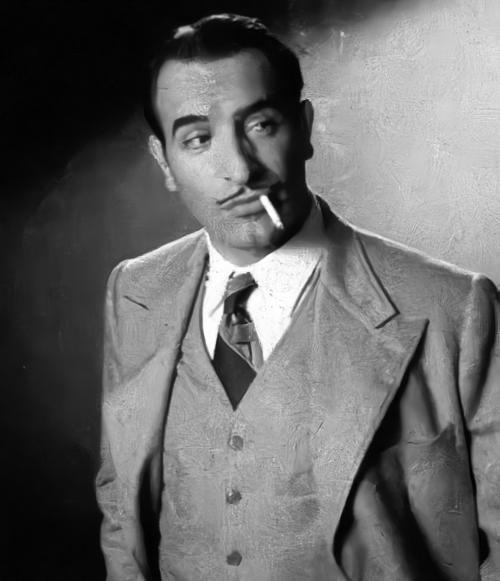
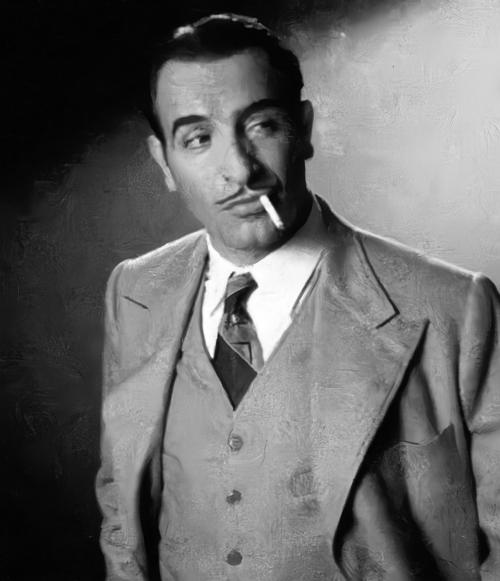
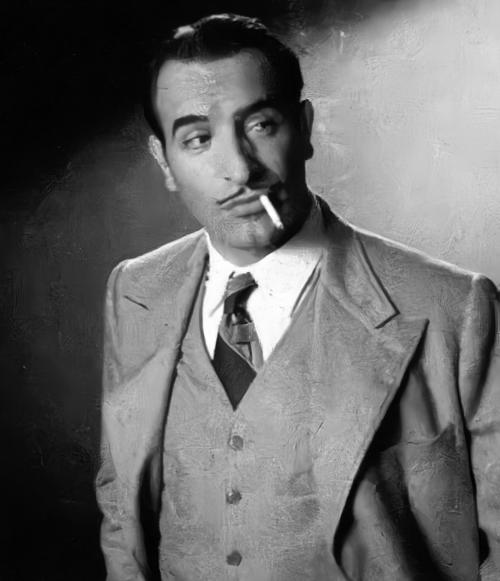

In [68]:
res_test_all_dncnn = utils.test_dncnn_algos('images/test007.jpg', alpha0, c0, sigma0, display=True) 

## Another Denoising scheme using our knowledge about the distribution

The Gaussian approximation of the mixed Poisson/Gaussian noise seems to actually work pretty good in our examples. However, for the same noise level we saw that the denoising was actually much better with a true Gaussian noise. Hence, we can imagine that an algorithm that would be able to use the structure of the mixed Poisson-Gaussian noise would be able to reach better performance. 

The problem is that in practice we only have gaussian denoisers, so we need to continue to use gaussian denoising at some point. The plug-and-play ADMM (Alternative Direction Method of Multiplier) by using an iterative scheme involving the Likelihood of the observation under the posterior distribution and a Gaussian denoiser.

We propose an implementation of this algorithm below.

The main difficulty in this algorithm is the update of the variable $x$. Indeed, it requires to compute the maximum posterior log-likelihood of the noisy observation, which is a convolution of a Gaussian and a Poisson variable. This computation is expensive and a continuous maximization seems untractable. For this reason, we first wrote some functions to compute the probabilities for each pixel value $(x, y) \in [1,255] \times [1, 255]$. Then we approximate all likelihoods by the likelihoods of the rounding integer of each value.

``` python
from scipy.stats import poisson
from scipy.stats import norm

def logp_scipy(x, y, alpha, c, sigma, tol=1e-4):
    p = poisson(x)
    n = norm(y-c, sigma)
    max_range = np.sqrt(-2*sigma**2*np.log(tol))
    k_range = np.arange(max(int((y-c-max_range)/alpha), 0), min(int((y-c+max_range)/alpha), 300))
    prob_list = np.zeros(k_range.shape[0])
    for i, k in enumerate(k_range):
        prob_list[i] = p.logpmf(k) + n.logpdf(alpha * k)
    a = prob_list.max()
    return a + np.log(np.exp(prob_list-a).sum())
```

```python
def update_x(im, prob, rho, u, v):
    """
    :param im: Noisy Image
    :param prob: grid of observation conditional likelihood
    :param rho: strength of regularization
    :param u: Lagrange multiplier
    :param v: Slack variable for x
    :return: New value of x maximizing regularized log-likelihood
    """
    new_x = np.zeros(im.shape)
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            y = im[i, j]
            index = max(1, min(255, int(round(y, 0))))
            obj = -prob[:, index-1] + rho/2 * (np.arange(1, 256) - v[i, j] + u[i, j])**2
            new_x[i, j] = obj.argmin()
    return new_x


def ADMM(im, alpha, c, sigma, denoiser, l, param, tol, max_iter, im_clean):
    """
    :param im: Input Image
    :param alpha: Underlying model scaling of poisson noise
    :param c: Underlying model mean of the gaussian noise
    :param sigma: Underlying model noise
    :param denoiser: Denoising algorithm class used in test_denoiser, is instanced with a certain sigma
    at each iteration
    :param l: Regularization parameter
    :param param: Parameters of the continuation scheme (rho, eta, gamma): Starting value, update criterion
    and update rate
    :param tol: tolerance for convergence
    :param max_iter: maximum number of loops before stopping the algorithm
    :return:
    """
    delta = tol + 0.01
    rho, eta, gamma = param
    n_iter = 0
    # x = np.random.uniform(0, 255, size=im.shape)
    im = (copy(im) - c)/alpha
    x = copy(im)
    prob_array = read_proba_grid(int(sigma/alpha), best_match=True)
    v, u = copy(x), np.zeros(im.shape)
    pbar = tqdm(total=max_iter)
    out_x, out_v = [], []
    PSNR_x, PSNR_v = [], []
    while delta > tol and n_iter < max_iter:
        n_iter += 1
        xp, vp, up, delta_p = copy(x), copy(v), copy(u), copy(delta)
        x = update_x(im, prob_array, rho, u, v)
        sig_denoiser = np.sqrt(l/rho)
        v = test_denoiser(denoiser(sig_denoiser), x+u, None, has_noise=True)[0]
        v = v[0, 0, :, :].numpy()
        u += x - v
        delta = compute_delta(x, v, u, xp, vp, up)
        if delta >= eta * delta_p:
            rho *= gamma
        pbar.update(1)
        out_x.append(x)
        out_v.append(v)
        if im_clean is not None:
            PSNR_x.append(PSNR(x, im_clean))
            PSNR_v.append(PSNR(v, im_clean))
    return (x+v)/2, out_x, out_v, PSNR_x, PSNR_v
```

In [78]:
res_ADMM = utils.ADMM(im0[1], alpha0, c0, sigma0, DnCNN_pretrained_grayscale,
               l=0.6, param=(1e-3, 0.85, 1.5), tol=1e-3, max_iter=10, im_clean=im0[0])

Downloaded model for sigma= 30.000000 instead of sigma=25.000000











  0%|                                                                                           | 0/10 [00:00<?, ?it/s]










 10%|████████▎                                                                          | 1/10 [00:05<00:53,  5.93s/it]








 20%|████████████████▌                                                                  | 2/10 [00:12<00:49,  6.14s/it]








 30%|████████████████████████▉                                                          | 3/10 [00:19<00:45,  6.43s/it]








 40%|█████████████████████████████████▏                                                 | 4/10 [00:25<00:38,  6.36s/it]








 50%|█████████████████████████████████████████▌                                         | 5/10 [00:32<00:32,  6.41s/it]








 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:38<00:25,  6.37s/it]








 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:45<00:19,  6.59s/it]








 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 










 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:58<00:06,  6.46s/it]










100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:05<00:00,  6.65s/it]


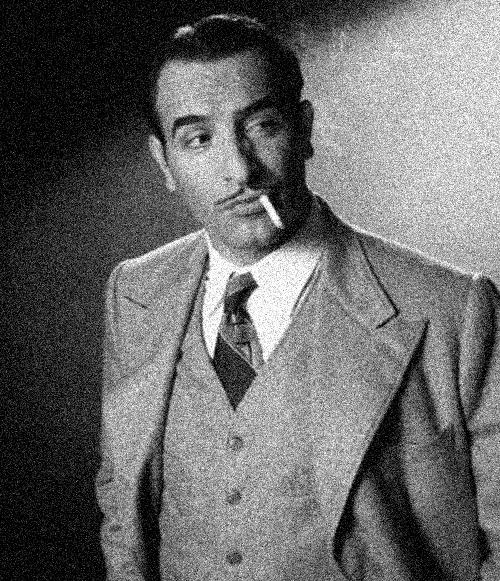
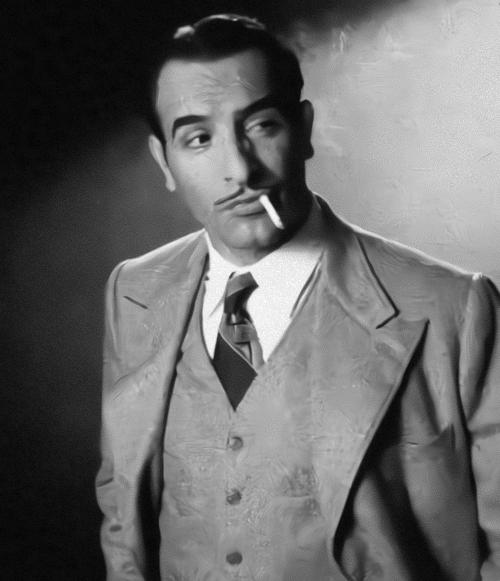
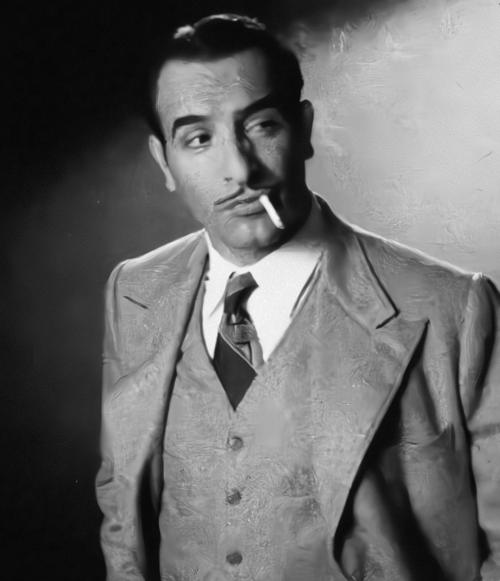
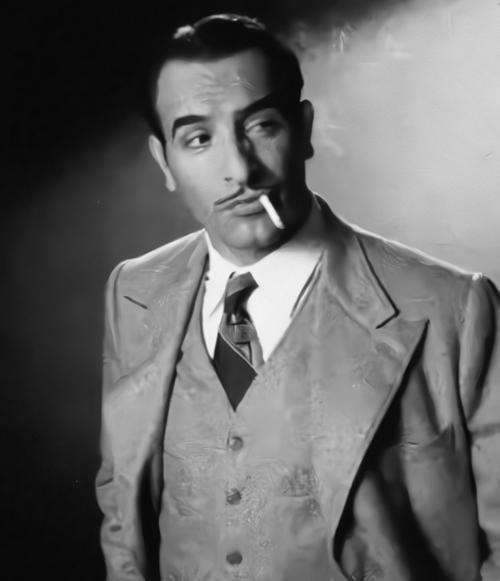
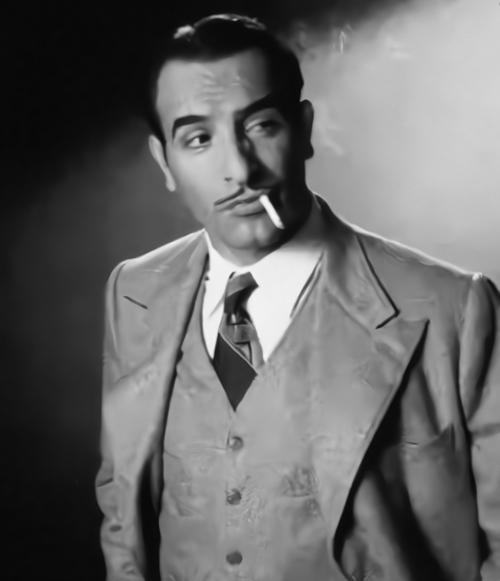
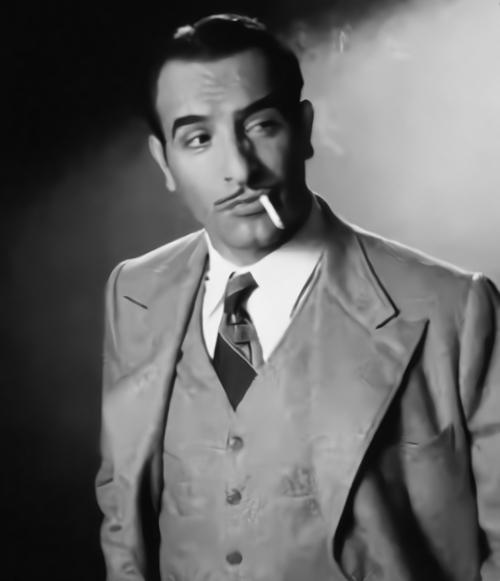
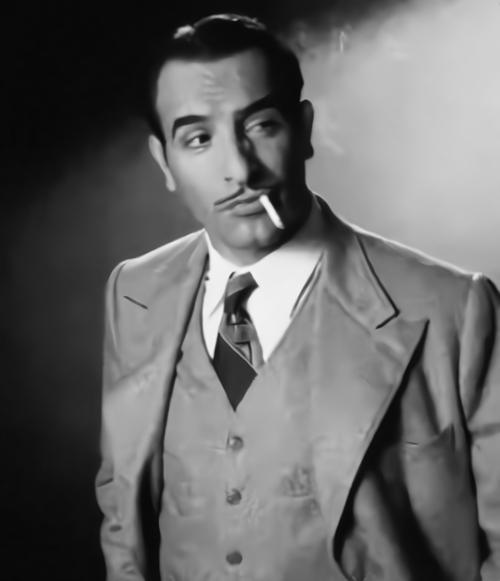
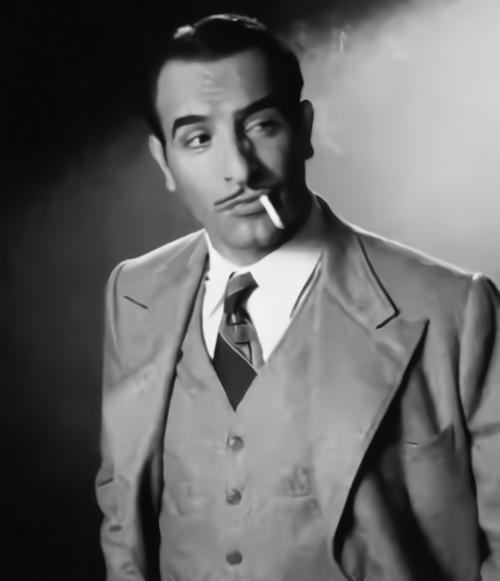
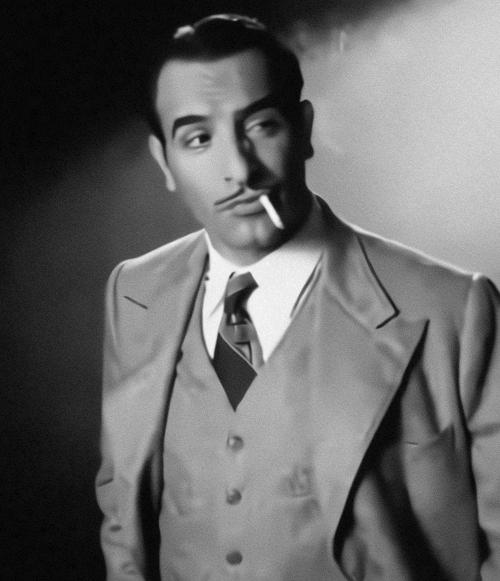
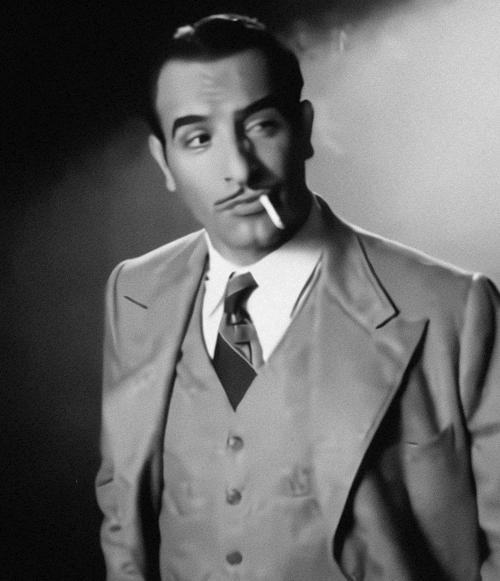


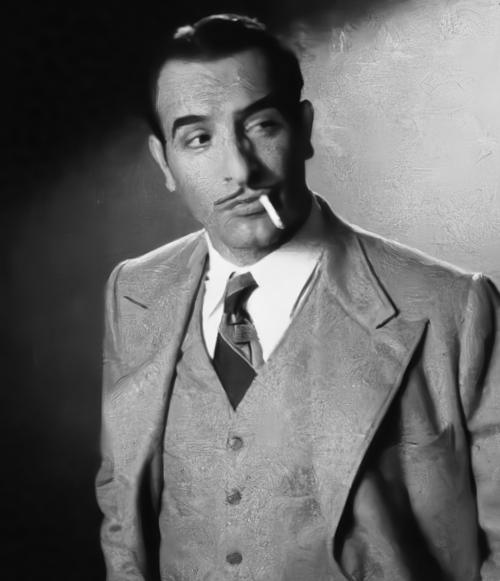
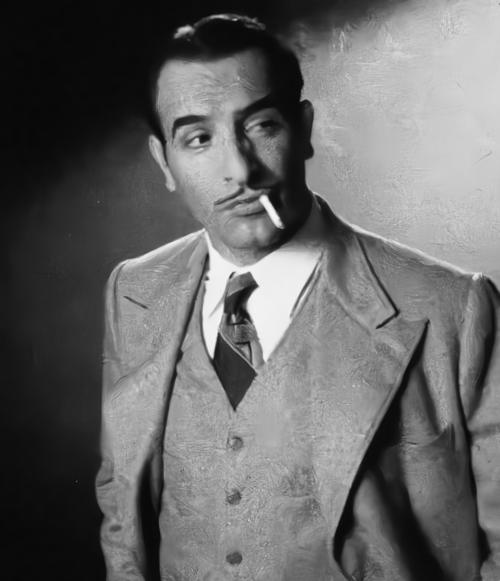
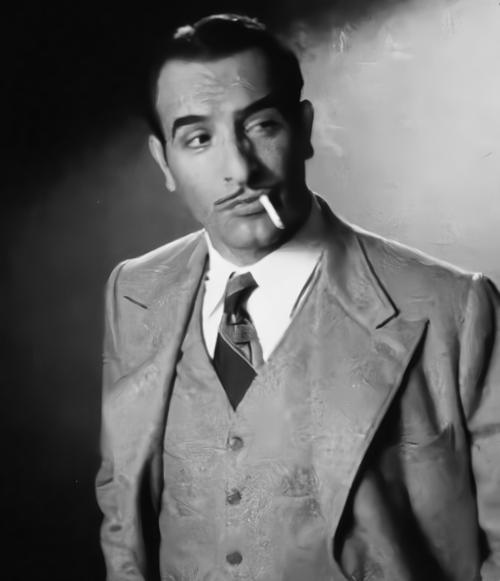
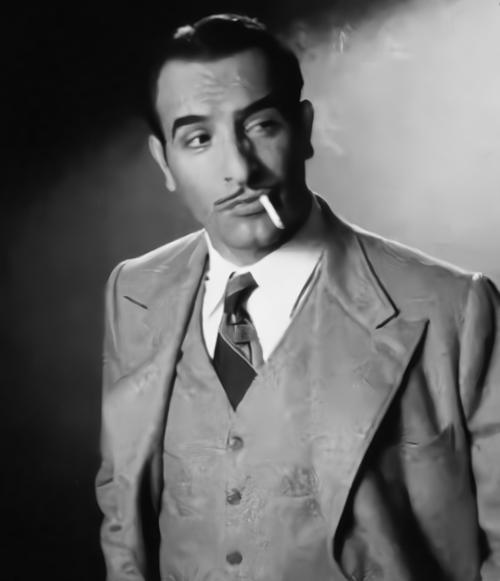
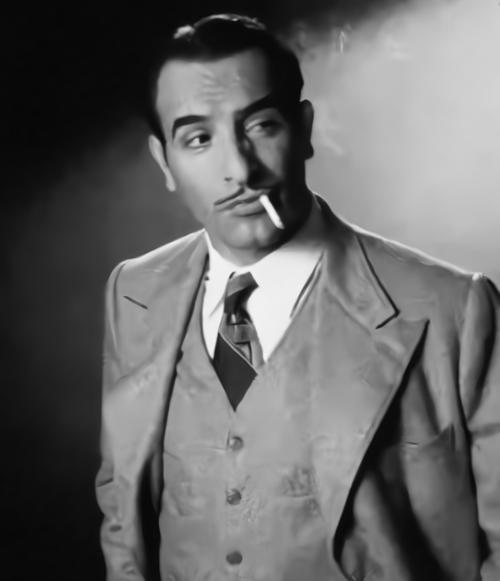
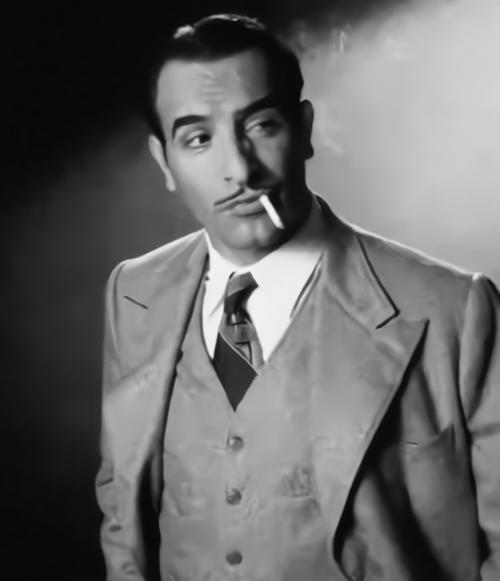
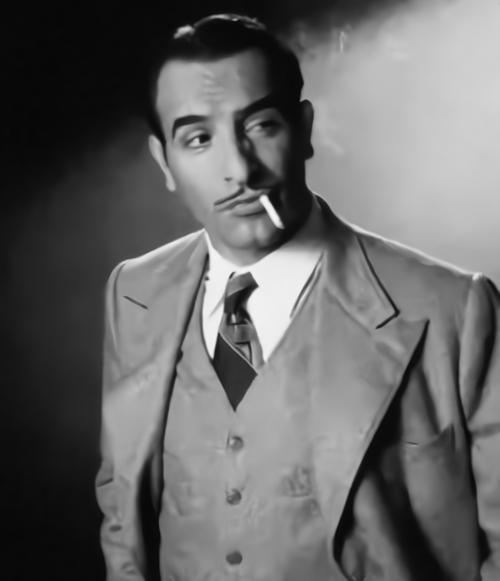
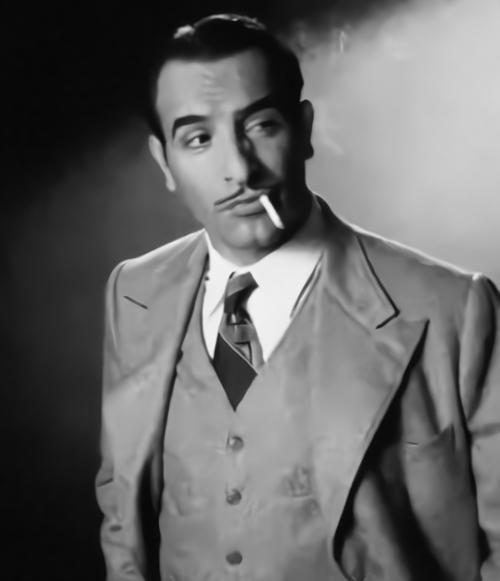
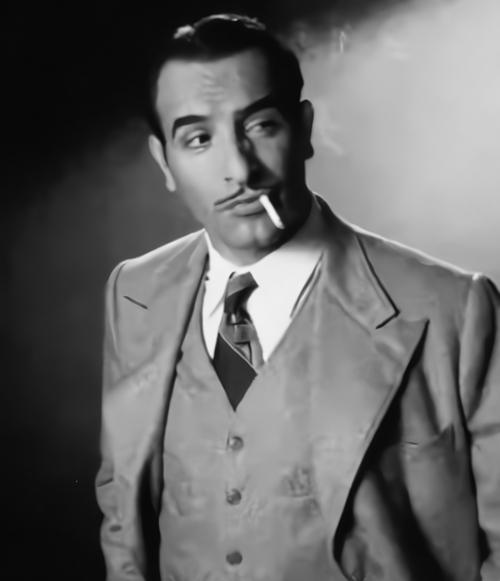
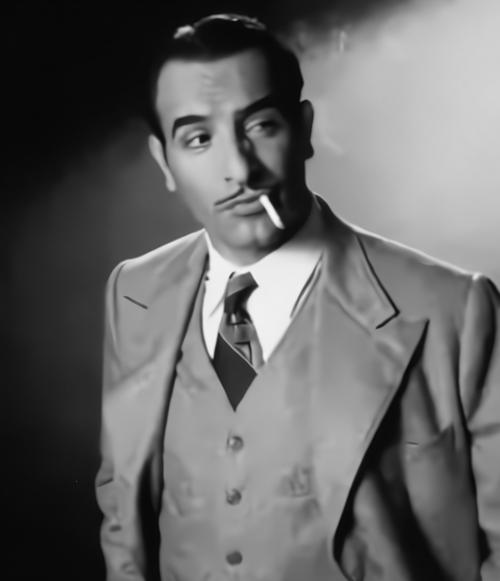

[20.037492033572, 30.620572034722166, 31.330126860997105, 31.685791965246036, 31.735227625483844, 31.726467867285457, 31.708723121666008, 31.68917058758526, 30.04149669347165, 30.059971384226166]
[31.06371288509413, 31.17758986513927, 31.78025336161161, 31.832613449676444, 31.80247464884854, 31.76413791722058, 31.732512063026665, 31.70720070630429, 31.75967431072436, 31.568669803133997]


In [79]:
vistools.display_gallery(res_ADMM[1])
vistools.display_gallery(res_ADMM[2])
print(res_ADMM[3])
print(res_ADMM[4])